Lesson: M931LT1 Artificial Intelligence II

Fall Semester 2021

Student's name: Christina Christodoulou

I.D Number: LT1200027

Field of Studies: Language Technology

Homework 2

In [1]:
# Import necessary libraries
import re 
import torch
import matplotlib.pyplot as plt 
import pandas as pd  
import pickle
import nltk
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
from numpy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, classification_report
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Download necessary packages
nltk.download('stopwords')
nltk.download('punkt')
stop_words_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**GENERAL AND NECESSARY FUNCTIONS USED**

In [2]:
# A function that opens, reads a file in csv with utf-8 encoding, gets the values, checks and fills empty values and checks for duplicates
def read_explore_dataframe(csv_file):
  
  # Open and read the csv file with utf-8 encoding
  dataframe = pd.read_csv(csv_file,encoding='utf-8')
  
  # Get the keys and their corresponding number of values
  keys = dataframe.keys() 
  for key in keys:
    df_len = len(dataframe[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))

  dataframe.dropna(inplace=True) # remove missing values and keep the dataFrame with valid entries in the same variable
  dataframe.reset_index(inplace=True,drop=True)

  dataframe.duplicated() # check for duplicates
  #print('Number of duplicates in the dataframe:', dataframe.duplicated().sum())
  print('Dataframe checked for NaN values and duplicates!')
  
  return dataframe 

In [3]:
# A function that takes as parameter a text and applies pre-processing steps to clean it
def text_preprocessing(text):
  
  # Remove tags
  TAG_RE = re.compile(r'<[^>]+>')
  no_tags = TAG_RE.sub('',text)  
                
  # Remove unusual characters
  text = re.sub('<[^>]*>', '', no_tags)

  # Remove urls
  text = re.sub(r'http\S+','', text)
    
  # Remove emoticons
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

  # Remove punctuation
  no_punct = [word for word in emoticons if word.isalpha()]
                
  # Convert all words to lowercase
  text = re.sub('[\W]+', ' ', text.lower()) + " ".join(no_punct).replace('-', '')
    
  # Remove numbers
  no_numbers_txt = re.sub(r'\d+', '', text)

  return no_numbers_txt

In [4]:
# A function that gets as input the dataframe and gets the necessary values from the columns after resampling and pre-processing
def get_columns(dataframe, feature, label):
  
  # Get only the columns we are interested in
  dataset = dataframe[[feature,label]]
  
  # Check the distribution of classes
  distribution = dataset[label].value_counts()/dataset.shape[0]
  print('Distribution of data in classes:')
  print(distribution)

  # Separate the different labels and create a combined dataset
  neutral = dataset[dataset[label] == 0]
  antivax = dataset[dataset[label] == 1]
  provax = dataset[dataset[label] == 2]

  # Combine the classes with the greater number of values
  class_majorities = pd.concat([neutral,provax])
  classes = pd.concat([neutral,antivax,provax])

  # Upsampling: take samples with replacement from the minority class until the class is almost the same size as the majorities
  train_minority_upsampled = resample(antivax, replace=True, n_samples=len(classes),random_state=123)
  train_minority_upsampled2 = resample(neutral, replace=True, n_samples=len(classes),random_state=123)
  train_minority_upsampled3 = resample(provax, replace=True, n_samples=len(classes),random_state=123)
  
  # Combine in a new dataframe the new resampled classes 
  dataset = pd.concat([train_minority_upsampled,train_minority_upsampled2,train_minority_upsampled3]) 
  print('Distribution of data in classes after resampling:')
  print(dataset[label].value_counts())
  
  # Apply the pre-processing function to the dataframe containing the text (feature column)
  dataset[feature] = dataset[feature].apply(text_preprocessing)
  print('\nText done pre-processing!')
  
  # Divide the X and y values
  X = dataset[feature]
  y = dataset[label]
  
  # Print to see the input variables
  #print(X[:2])

  return X,y

In [5]:
# A function that creates tensors 
def create_tensors(x, y):
  
  # Convert X datasets to tensors
  X_train_tensor = torch.tensor(x, dtype=torch.float)   
   
  # Convert Y labels to tensors 
  Y_test_tensor = torch.squeeze(torch.from_numpy(y.to_numpy()).float())
  print('Tensors ready!')

  return X_train_tensor, Y_test_tensor

In [6]:
index = 0
word_to_index = {}
words = []
vectors = []

# Open the glove txt file and get the words and their corresponding vectors
with open('glove.twitter.27B.25d.txt', 'rb') as file:
  for i in file:  
    line = i.decode().split()
    # Get the word
    word = line[0]
    words.append(word)
    word_to_index[word] = index
    index += 1
    # Get the vector
    vector = np.array(line[1:]).astype(np.float)
    vectors.append(vector)

glove = {w: vectors[word_to_index[w]] for w in words}

# Save the GloVe dictionary into pickle form
#glove_file = open('/content/glove_dict_25d.pkl', 'wb')
#pickle.dump(glove,glove_file)
#glove_file.close()
#print('Glove dictionary saved in pickle!')


# A function that searches for each word in the dataset whether it exists in Glove's dictionary and loads the pre-trained word vector, 
# otherwise initializes it with zero. At the end, it finds the mean vector of each tweet. 
def find_words_in_glove(train_dataset):

  matrix_length = len(train_dataset)  
  weights_matrix = np.zeros((matrix_length, 25))
  words_found = 0
  words = 0
  mean_tweets = []

  for i,row in enumerate(train_dataset):
    splited_words = str(row).split(' ')
    weight_matrix = np.zeros((len(splited_words), 25))
    for j,word in enumerate(splited_words): 
      words += 1
      if word in glove:
        weight_matrix[j] = glove[word]
        words_found += 1
    mean_tweets.append(np.mean(weight_matrix, axis=0))

  return np.array(mean_tweets), words_found, matrix_length

In [7]:
# A function that trains a neural network model
def train_neural_network_model(epochs,model,dataloader,optimizer,loss_func):

  model.train() 
  
  current_loss = 0   
  correct = 0
  total = 0
  
  # Training part 
  for data, target in tqdm(dataloader):
    # Forward pass to get output      
    output = model.forward(data)
    # Calculate the loss
    loss_train = loss_func(output, target.long())
    # Clearing up accumulated gradients
    optimizer.zero_grad()
    # Getting gradients
    loss_train.backward()
    # Updating parameters
    optimizer.step()
    # Count the training loss
    current_loss += loss_train.item()
    
    _, predicted = output.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().item()

  # Count the loss for each epoch
  train_loss= current_loss/len(dataloader)
  # Count the accuracy for each epoch
  train_accu =100.*correct/total
  print('Train Loss: {} | Accuracy: {}'.format(train_loss,train_accu))

  return train_loss,train_accu


# A function that evaluates a trained neural network model
def evaluate_neural_network_model(epochs,model,dataloader,optimizer,loss_func):
    
  model.eval()
       
  current_loss = 0  
  correct = 0
  total = 0
  
  # Evaluation part
  with torch.no_grad(): 
    for data_val, labels in tqdm(dataloader):
      # Forward pass to get output 
      outputs = model.forward(data_val)
      # Calculate the loss
      loss_val = loss_func(outputs, labels.long())
      # Count the validation loss
      current_loss += loss_val.item()

      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  # Count the loss for each epoch
  val_loss = current_loss/len(dataloader)
  # Count the accuracy for each epoch
  accu = 100.*correct/total
  print('Test Loss: {} | Accuracy: {}'.format(val_loss, accu))
  
  return val_loss, accu

In [8]:
# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, y_pred):  
  
  y_pred = torch.round(y_pred)
  _,pred_label = torch.max(y_pred, dim = 1)
  
  print('\nCalculating metrics...')
  # Calculate accuracy of model
  correct = (pred_label == y_true).float()
  acc = correct.sum() / len(correct)

  # Calculate general precision, recall, F1 score of model and of each class
  precision, recall, fscore, support = score(y_true,pred_label)
  print('Accuracy: {}'.format(acc))
  print('Precision: {}'.format(precision))
  print('Recall: {}'.format(recall))
  print('F1 score: {}'.format(fscore))
  print('Support: {}'.format(support))

  # Print classification report
  print(classification_report(y_true,pred_label))

**USED ONLY IN THE FIRST FEED-FORWARD NETWORK MODEL**

In [9]:
# A class that initializes a feed-forward neural network model for the first model
class feedforward_neural_network_model(nn.Module):
    
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(feedforward_neural_network_model, self).__init__()
              
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1) 
        self.relu_1 = nn.ReLU()
    
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)   
        self.relu_2 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch = nn.BatchNorm1d(hidden_dim_2)
 
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)  

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)
        
        out = self.layer_2(out)
        out = self.relu_2(out)
        out = self.batch(out)
        out = self.dropout(out)

        out = self.layer_3(out)
        
        return torch.sigmoid(out)

In [10]:
# A function made for the first feed-forward training model
# The main function running all the rest

def data_train_first_model(csv_file_train, csv_file_test, glove_file_pickle, feature, label):
  
  # Prepare the training dataset
  print('------ Preparing the training dataset... ------')
  df_train = read_explore_dataframe(csv_file_train)
  X,y = get_columns(df_train, feature, label)
  
  # Prepare the validation/testing dataset
  print('\n------ Preparing the validation/testing dataset... ------')
  df_test = read_explore_dataframe(csv_file_test)
  x1,y1 = get_columns(df_test, feature, label)
  
  # Load the GloVe dictionary in pickle form
  glove_file = open(glove_file_pickle, 'rb')
  glove = pickle.load(glove_file)
  
  gloveX_train, words_found, matrix_len = find_words_in_glove(X)
  print('Percentage of words founded in Glove: ', words_found/matrix_len)

  gloveX_test, words_found, matrix_len = find_words_in_glove(x1)
  print('Percentage of words founded in Glove: ', words_found/matrix_len)

  # Create tensors for the training and testing/validation sets
  training_X_tensor, training_Y_tensor = create_tensors(gloveX_train,y)
  testing_X_tensor, testing_Y_tensor = create_tensors(gloveX_test,y1)

  # Initialize dataloader for train set
  dataset_1 = torch.utils.data.TensorDataset(training_X_tensor, training_Y_tensor)
  dataloader_train = torch.utils.data.DataLoader(dataset_1, batch_size = 6, shuffle = True)

  # Initialize dataloader for validation set
  dataset_2 = torch.utils.data.TensorDataset(testing_X_tensor, testing_Y_tensor)
  dataloader_val = torch.utils.data.DataLoader(dataset_2, batch_size = 6, shuffle = False)

  # Define dimensions of each layer and number of epochs
  input_layer = training_X_tensor.shape[1]
  hidden_layer_1 = 32
  hidden_layer_2 = 16
  output_layer = 3
  num_epochs = 30

  # Define the first feed forward neural network
  first_model = feedforward_neural_network_model(input_layer, hidden_layer_1, hidden_layer_2, output_layer)
  print(first_model)

  # Define loss function
  loss_function = nn.CrossEntropyLoss()

  # Define as optimizer Adam
  optimizer = optim.Adam(first_model.parameters(), lr = 0.0001, weight_decay = 1e-4)

  # Initialize empty lists to store the values of loss and accuracy for each epoch
  train_acc = []
  train_loss = []
  eval_acc = []
  eval_loss = []

  print('\n------ Training on the training set and evaluating on the validation/testing set.... ------')

  for epoch in range(1,num_epochs+1):
    print('\nEpoch: %d'%epoch)

    # Train the model using the train_neural_network function
    train_losses, train_accuracy = train_neural_network_model(epoch,first_model,dataloader_train,optimizer,loss_function)
 
    # Evaluate the model using the evaluate_neural_network_model function
    evaluation_losses, evaluation_accuracy = evaluate_neural_network_model(epoch,first_model,dataloader_val,optimizer,loss_function)

    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_acc.append(train_accuracy)
    train_loss.append(train_losses)
    eval_acc.append(evaluation_accuracy)
    eval_loss.append(evaluation_losses)

  # Plot the loss vs epochs 
  plt.plot(train_loss,'-o')
  plt.plot(eval_loss,'-o')
  plt.title('Train vs Validation/Test Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation/Test'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_acc,'-o')
  plt.plot(eval_acc,'-o')
  plt.title('Train vs Validation/Test Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation/Test'])
  plt.show()

  # Make predictions
  test_prediction = first_model(testing_X_tensor)

  # Calculate all the metrics on the validation/test set
  test_metrics = calculate_metrics(testing_Y_tensor,test_prediction)
  print(test_metrics)

  # Convert tensors to numpy arrays
  y_score = test_prediction.detach().numpy()
  y = testing_Y_tensor.detach().numpy()

  # Label binarization and store the number of classes
  y_test = label_binarize(y, classes=[0, 1, 2])
  n_classes = y_test.shape[1]

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
  lw = 2

  # Plot all ROC curves
  plt.figure()
  plt.plot(
    fpr['micro'],
    tpr['micro'],
    label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color='deeppink',
    linestyle=':',
    linewidth=4,)

  plt.plot(
    fpr['macro'],
    tpr['macro'],
    label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color='navy',
    linestyle=':',
    linewidth=4,)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label= 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Roc curve for all classes')
  plt.legend(loc='lower right')
  plt.show()

**USED ONLY IN THE SECOND FEED-FORWARD NETWORK MODEL**

In [11]:
# A class that initializes a deeper feed-forward neural network model for the second model
class Feed_forward_Neural_Net_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4, output_dim):
        super(Feed_forward_Neural_Net_Model, self).__init__()
        
        
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)     
        self.relu_1 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
         
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)    
        self.relu_2 = nn.ReLU()
      
        self.layer_3 = nn.Linear(hidden_dim_2, hidden_dim_3) 
        self.relu_3 = nn.ReLU()
     
        self.layer_4 = nn.Linear(hidden_dim_3, hidden_dim_4)       
        self.relu_4 = nn.Softmax(dim = 1)
        self.dropout = nn.Dropout(0.3)
        self.batch = nn.BatchNorm1d(hidden_dim_4)

        self.layer_5 = nn.Linear(hidden_dim_4, output_dim)  

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)
        out = self.dropout(out)
        
        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)
        out = self.relu_3(out)

        out = self.layer_4(out)
        out = self.relu_4(out)
        out = self.dropout(out)
        out = self.batch(out)

        out = self.layer_5(out)

        return torch.sigmoid(out)

In [12]:
# A function made for the second feed-forward training model
def data_train_second_model(csv_file_train, csv_file_test, glove_file_pickle, feature, label):
  
  # Prepare the training dataset
  print('------ Preparing the training dataset... ------')
  df_train = read_explore_dataframe(csv_file_train)
  X,y = get_columns(df_train, feature, label)
  
  # Prepare the validation/testing dataset
  print('\n------ Preparing the validation/testing dataset... ------')
  df_test = read_explore_dataframe(csv_file_test)
  x1,y1 = get_columns(df_test, feature, label)
  
  # Load the GloVe dictionary in pickle form
  glove_file = open(glove_file_pickle, 'rb')
  glove = pickle.load(glove_file)
  
  gloveX_train, words_found, matrix_len = find_words_in_glove(X)
  print('Percentage of words founded in Glove: ', words_found/matrix_len)

  gloveX_test, words_found, matrix_len = find_words_in_glove(x1)
  print('Percentage of words founded in Glove: ', words_found/matrix_len)

  # Create tensors for the training and testing/validation sets
  training_X_tensor, training_Y_tensor = create_tensors(gloveX_train,y)
  testing_X_tensor, testing_Y_tensor = create_tensors(gloveX_test,y1)

  # Initialize dataloader for train set
  dataset_1 = torch.utils.data.TensorDataset(training_X_tensor, training_Y_tensor)
  dataloader_train = torch.utils.data.DataLoader(dataset_1, batch_size = 10, shuffle = True)

  # Initialize dataloader for validation set
  dataset_2 = torch.utils.data.TensorDataset(testing_X_tensor, testing_Y_tensor)
  dataloader_val = torch.utils.data.DataLoader(dataset_2, batch_size = 10, shuffle = False)

  # Define dimensions of each layer and number of epochs
  input_layer = training_X_tensor.shape[1]
  hidden_layer_1 = 500
  hidden_layer_2 = 256
  hidden_layer_3 = 128
  hidden_layer_4 = 64
  output_layer = 3
  num_epochs = 40

  # Define the first feed forward neural network
  second_model = Feed_forward_Neural_Net_Model(input_layer, hidden_layer_1, hidden_layer_2, hidden_layer_3, hidden_layer_4, output_layer)
  print(second_model)

  # Define loss function
  loss_function = nn.CrossEntropyLoss()

  # Define as optimizer Adam
  optimizer = optim.SGD(second_model.parameters(), lr = 0.01, weight_decay = 1e-4)

  # Initialize empty lists to store the values of loss and accuracy for each epoch
  train_acc = []
  train_loss = []
  eval_acc = []
  eval_loss = []

  print('\n------ Training on the training set and evaluating on the validation/testing set.... ------')

  for epoch in range(1,num_epochs+1):
    print('\nEpoch: %d'%epoch)

    # Train the model using the train_neural_network function
    train_losses, train_accuracy = train_neural_network_model(epoch,second_model,dataloader_train,optimizer,loss_function)
 
    # Evaluate the model using the evaluate_neural_network_model function
    evaluation_losses, evaluation_accuracy = evaluate_neural_network_model(epoch,second_model,dataloader_val,optimizer,loss_function)

    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_acc.append(train_accuracy)
    train_loss.append(train_losses)
    eval_acc.append(evaluation_accuracy)
    eval_loss.append(evaluation_losses)

  # Plot the loss vs epochs 
  plt.plot(train_loss,'-o')
  plt.plot(eval_loss,'-o')
  plt.title('Train vs Validation/Test Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation/Test'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_acc,'-o')
  plt.plot(eval_acc,'-o')
  plt.title('Train vs Validation/Test Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation/Test'])
  plt.show()

  # Make predictions
  test_prediction = second_model(testing_X_tensor)

  # Calculate all the metrics on the validation/test set
  test_metrics = calculate_metrics(testing_Y_tensor,test_prediction)
  print(test_metrics)

  # Convert tensors to numpy arrays
  y_score = test_prediction.detach().numpy()
  y = testing_Y_tensor.detach().numpy()

  # Label binarization and store the number of classes
  y_test = label_binarize(y, classes=[0, 1, 2])
  n_classes = y_test.shape[1]

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
  lw = 2

  # Plot all ROC curves
  plt.figure()
  plt.plot(
    fpr['micro'],
    tpr['micro'],
    label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color='deeppink',
    linestyle=':',
    linewidth=4,)

  plt.plot(
    fpr['macro'],
    tpr['macro'],
    label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color='navy',
    linestyle=':',
    linewidth=4,)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label= 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Roc curve for all classes')
  plt.legend(loc='lower right')
  plt.show()

**APPLICATION OF FUNCTIONS**

NOTE: For the test set to run, just change the name of the second csv file ('vaccine_validation_set.csv').

**TRAINING & EVALUATING THE FIRST FEED-FORWARD NEURAL NETWORK USING PRE-TRAINED WORD EMBEDDING VECTORS**

------ Preparing the training dataset... ------
Unnamed: 0                    15976
tweet                         15881
label                             3
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466825
2    0.403418
1    0.129757
Name: label, dtype: float64
Distribution of data in classes after resampling:
2    15976
1    15976
0    15976
Name: label, dtype: int64

Text done pre-processing!

------ Preparing the validation/testing dataset... ------
Unnamed: 0                     2282
tweet                          2276
label                             3
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466696
2    0.403593
1    0.129711
Name: label, dtype: float64
Distribution of data in classes after resampling:
2    2282
1    2282
0    2282
Name: label, dtype: int64

Text done pre-processing!
Percentage of words founded in Glove:  17.947588048739778
Percentage of words founded in Glove:  17.7919

100%|██████████| 7988/7988 [00:11<00:00, 709.60it/s]


Train Loss: 1.0530759239038587 | Accuracy: 45.6351193456852


100%|██████████| 1141/1141 [00:00<00:00, 3000.24it/s]


Test Loss: 0.9935788767156007 | Accuracy: 53.78323108384458

Epoch: 2


100%|██████████| 7988/7988 [00:11<00:00, 726.16it/s]


Train Loss: 1.0043438287917292 | Accuracy: 51.934151226840264


100%|██████████| 1141/1141 [00:00<00:00, 3010.35it/s]


Test Loss: 0.9623181542526934 | Accuracy: 57.08442886356997

Epoch: 3


100%|██████████| 7988/7988 [00:11<00:00, 695.29it/s]


Train Loss: 0.9845177414391001 | Accuracy: 53.690953096311134


100%|██████████| 1141/1141 [00:00<00:00, 2991.43it/s]


Test Loss: 0.9536770739960733 | Accuracy: 58.092316681273736

Epoch: 4


100%|██████████| 7988/7988 [00:11<00:00, 709.26it/s]


Train Loss: 0.9767547127495543 | Accuracy: 54.32732431981305


100%|██████████| 1141/1141 [00:00<00:00, 2997.52it/s]


Test Loss: 0.9437070975274396 | Accuracy: 57.78556821501607

Epoch: 5


100%|██████████| 7988/7988 [00:11<00:00, 721.63it/s]


Train Loss: 0.9685867065615098 | Accuracy: 55.11392088132198


100%|██████████| 1141/1141 [00:00<00:00, 3047.44it/s]


Test Loss: 0.9398231599855381 | Accuracy: 58.03388840198656

Epoch: 6


100%|██████████| 7988/7988 [00:11<00:00, 719.65it/s]


Train Loss: 0.9640161829348141 | Accuracy: 55.687698213987645


100%|██████████| 1141/1141 [00:00<00:00, 3162.91it/s]


Test Loss: 0.9393311784938174 | Accuracy: 57.610283377154545

Epoch: 7


100%|██████████| 7988/7988 [00:10<00:00, 744.07it/s]


Train Loss: 0.9633348265333539 | Accuracy: 55.82123184777166


100%|██████████| 1141/1141 [00:00<00:00, 3010.12it/s]


Test Loss: 0.9342865167115468 | Accuracy: 58.983347940403156

Epoch: 8


100%|██████████| 7988/7988 [00:10<00:00, 733.16it/s]


Train Loss: 0.9563457889815361 | Accuracy: 56.332415289601066


100%|██████████| 1141/1141 [00:00<00:00, 3150.48it/s]


Test Loss: 0.9293481853842004 | Accuracy: 58.51592170610576

Epoch: 9


100%|██████████| 7988/7988 [00:10<00:00, 738.21it/s]


Train Loss: 0.9557946957106822 | Accuracy: 56.50767818394258


100%|██████████| 1141/1141 [00:00<00:00, 3315.14it/s]


Test Loss: 0.9301370011412398 | Accuracy: 59.50920245398773

Epoch: 10


100%|██████████| 7988/7988 [00:11<00:00, 722.23it/s]


Train Loss: 0.9538239025747293 | Accuracy: 56.70589217159072


100%|██████████| 1141/1141 [00:00<00:00, 3200.66it/s]


Test Loss: 0.9272384979451151 | Accuracy: 59.69909436167105

Epoch: 11


100%|██████████| 7988/7988 [00:10<00:00, 727.40it/s]


Train Loss: 0.9500563741700316 | Accuracy: 57.00425638457686


100%|██████████| 1141/1141 [00:00<00:00, 3065.15it/s]


Test Loss: 0.9326481955496498 | Accuracy: 58.04849547180836

Epoch: 12


100%|██████████| 7988/7988 [00:10<00:00, 747.00it/s]


Train Loss: 0.949241301224837 | Accuracy: 57.271323652144886


100%|██████████| 1141/1141 [00:00<00:00, 3213.99it/s]


Test Loss: 0.924716831402858 | Accuracy: 58.80806310254163

Epoch: 13


100%|██████████| 7988/7988 [00:10<00:00, 736.70it/s]


Train Loss: 0.9483644590639865 | Accuracy: 57.49457519612753


100%|██████████| 1141/1141 [00:00<00:00, 2849.74it/s]


Test Loss: 0.9246964128157426 | Accuracy: 59.94741454864154

Epoch: 14


100%|██████████| 7988/7988 [00:10<00:00, 727.40it/s]


Train Loss: 0.9479988517839429 | Accuracy: 57.26923718911701


100%|██████████| 1141/1141 [00:00<00:00, 3145.45it/s]


Test Loss: 0.928083958017732 | Accuracy: 59.12941863862109

Epoch: 15


100%|██████████| 7988/7988 [00:10<00:00, 740.04it/s]


Train Loss: 0.9461104148811379 | Accuracy: 57.54882323485228


100%|██████████| 1141/1141 [00:00<00:00, 2999.67it/s]


Test Loss: 0.9235625225760036 | Accuracy: 60.38562664329535

Epoch: 16


100%|██████████| 7988/7988 [00:10<00:00, 745.11it/s]


Train Loss: 0.9440104691801396 | Accuracy: 57.911867801702556


100%|██████████| 1141/1141 [00:00<00:00, 3183.45it/s]


Test Loss: 0.9259147191131251 | Accuracy: 59.26088226701724

Epoch: 17


100%|██████████| 7988/7988 [00:11<00:00, 724.04it/s]


Train Loss: 0.9432890594274208 | Accuracy: 57.75746953763979


100%|██████████| 1141/1141 [00:00<00:00, 3057.03it/s]


Test Loss: 0.9255628196112844 | Accuracy: 59.655273152205666

Epoch: 18


100%|██████████| 7988/7988 [00:10<00:00, 736.50it/s]


Train Loss: 0.9394309295748972 | Accuracy: 58.23318310799532


100%|██████████| 1141/1141 [00:00<00:00, 2986.18it/s]


Test Loss: 0.926537019186747 | Accuracy: 59.348524685948

Epoch: 19


100%|██████████| 7988/7988 [00:10<00:00, 736.39it/s]


Train Loss: 0.9397327601984256 | Accuracy: 58.28117175763646


100%|██████████| 1141/1141 [00:00<00:00, 3058.54it/s]


Test Loss: 0.92646143809418 | Accuracy: 59.88898626935437

Epoch: 20


100%|██████████| 7988/7988 [00:10<00:00, 748.08it/s]


Train Loss: 0.9360700348316578 | Accuracy: 58.38132198297446


100%|██████████| 1141/1141 [00:00<00:00, 3134.18it/s]


Test Loss: 0.9239121363624787 | Accuracy: 59.74291557113643

Epoch: 21


100%|██████████| 7988/7988 [00:10<00:00, 749.48it/s]


Train Loss: 0.9354988401107449 | Accuracy: 58.61083291604073


100%|██████████| 1141/1141 [00:00<00:00, 3246.54it/s]


Test Loss: 0.9222165945326415 | Accuracy: 60.0350569675723

Epoch: 22


100%|██████████| 7988/7988 [00:10<00:00, 728.08it/s]


Train Loss: 0.9342621863186807 | Accuracy: 58.64004339843098


100%|██████████| 1141/1141 [00:00<00:00, 3082.68it/s]


Test Loss: 0.9252279306795386 | Accuracy: 60.23955594507742

Epoch: 23


100%|██████████| 7988/7988 [00:10<00:00, 750.48it/s]


Train Loss: 0.9309765244565967 | Accuracy: 59.09071941245201


100%|██████████| 1141/1141 [00:00<00:00, 2967.63it/s]


Test Loss: 0.9175027818349659 | Accuracy: 60.736196319018404

Epoch: 24


100%|██████████| 7988/7988 [00:10<00:00, 730.71it/s]


Train Loss: 0.9314348405384695 | Accuracy: 58.93840761141713


100%|██████████| 1141/1141 [00:00<00:00, 3196.15it/s]


Test Loss: 0.9274495132757216 | Accuracy: 60.31259129418638

Epoch: 25


100%|██████████| 7988/7988 [00:10<00:00, 753.93it/s]


Train Loss: 0.9302945933792074 | Accuracy: 59.03229844767151


100%|██████████| 1141/1141 [00:00<00:00, 3006.63it/s]


Test Loss: 0.9244517785848806 | Accuracy: 59.97662868828513

Epoch: 26


100%|██████████| 7988/7988 [00:10<00:00, 745.27it/s]


Train Loss: 0.930246597365791 | Accuracy: 59.2597229177099


100%|██████████| 1141/1141 [00:00<00:00, 2368.24it/s]


Test Loss: 0.9226169818644979 | Accuracy: 60.122699386503065

Epoch: 27


100%|██████████| 7988/7988 [00:10<00:00, 760.82it/s]


Train Loss: 0.9281570941329181 | Accuracy: 59.466282757469536


100%|██████████| 1141/1141 [00:00<00:00, 3286.56it/s]


Test Loss: 0.9192991595744668 | Accuracy: 59.96202161846334

Epoch: 28


100%|██████████| 7988/7988 [00:10<00:00, 761.63it/s]


Train Loss: 0.9269517583956286 | Accuracy: 59.447504590218664


100%|██████████| 1141/1141 [00:00<00:00, 3063.52it/s]


Test Loss: 0.9247543517692793 | Accuracy: 60.09348524685948

Epoch: 29


100%|██████████| 7988/7988 [00:10<00:00, 756.32it/s]


Train Loss: 0.9274405841088379 | Accuracy: 59.60607578033717


100%|██████████| 1141/1141 [00:00<00:00, 3152.40it/s]


Test Loss: 0.9236809411767697 | Accuracy: 59.42156003505697

Epoch: 30


100%|██████████| 7988/7988 [00:10<00:00, 757.01it/s]


Train Loss: 0.9258596542765632 | Accuracy: 59.6373727257553


100%|██████████| 1141/1141 [00:00<00:00, 3128.23it/s]


Test Loss: 0.9250019104934177 | Accuracy: 59.1148115687993


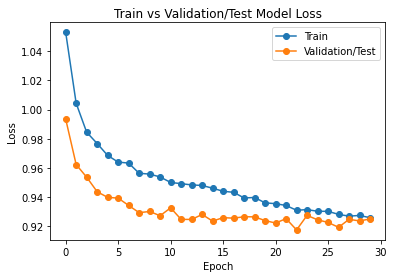

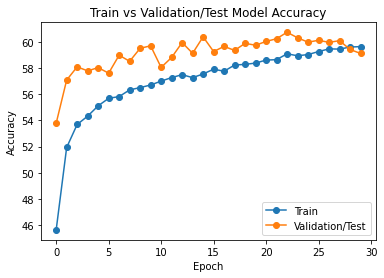


Calculating metrics...
Accuracy: 0.5817995667457581
Precision: [0.57580979 0.59016393 0.57777778]
Recall: [0.73225241 0.69412796 0.3190184 ]
F1 score: [0.64467593 0.63793798 0.41106719]
Support: [2282 2282 2282]
              precision    recall  f1-score   support

         0.0       0.58      0.73      0.64      2282
         1.0       0.59      0.69      0.64      2282
         2.0       0.58      0.32      0.41      2282

    accuracy                           0.58      6846
   macro avg       0.58      0.58      0.56      6846
weighted avg       0.58      0.58      0.56      6846

None


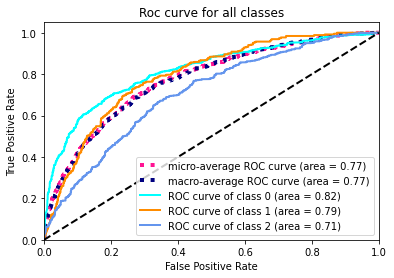

In [13]:
data_train_first_model('vaccine_train_set.csv', 'vaccine_validation_set.csv', 'glove_dict_25d.pkl', 'tweet', 'label')

**TRAINING & EVALUATING THE SECOND FEED-FORWARD NEURAL NETWORK USING PRE-TRAINED WORD EMBEDDING VECTORS**


------ Preparing the training dataset... ------
Unnamed: 0                    15976
tweet                         15881
label                             3
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466825
2    0.403418
1    0.129757
Name: label, dtype: float64
Distribution of data in classes after resampling:
2    15976
1    15976
0    15976
Name: label, dtype: int64

Text done pre-processing!

------ Preparing the validation/testing dataset... ------
Unnamed: 0                     2282
tweet                          2276
label                             3
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466696
2    0.403593
1    0.129711
Name: label, dtype: float64
Distribution of data in classes after resampling:
2    2282
1    2282
0    2282
Name: label, dtype: int64

Text done pre-processing!
Percentage of words founded in Glove:  17.947588048739778
Percentage of words founded in Glove:  17.7919

100%|██████████| 4793/4793 [00:11<00:00, 412.32it/s]


Train Loss: 1.100358997932337 | Accuracy: 34.15122684026039


100%|██████████| 685/685 [00:00<00:00, 1693.88it/s]


Test Loss: 1.093427943487237 | Accuracy: 43.748174116272274

Epoch: 2


100%|██████████| 4793/4793 [00:11<00:00, 413.03it/s]


Train Loss: 1.0798652820614019 | Accuracy: 39.123268235686865


100%|██████████| 685/685 [00:00<00:00, 1753.07it/s]


Test Loss: 1.0431431449242752 | Accuracy: 45.36955886649138

Epoch: 3


100%|██████████| 4793/4793 [00:11<00:00, 428.09it/s]


Train Loss: 1.0414788366458423 | Accuracy: 44.30395593390085


100%|██████████| 685/685 [00:00<00:00, 1698.47it/s]


Test Loss: 1.00843193992211 | Accuracy: 48.45165059888986

Epoch: 4


100%|██████████| 4793/4793 [00:11<00:00, 427.38it/s]


Train Loss: 1.0242449607153712 | Accuracy: 46.617843431814386


100%|██████████| 685/685 [00:00<00:00, 1737.78it/s]


Test Loss: 0.9925064103446738 | Accuracy: 50.102249488752555

Epoch: 5


100%|██████████| 4793/4793 [00:11<00:00, 433.69it/s]


Train Loss: 1.0158157286578322 | Accuracy: 47.61934568519446


100%|██████████| 685/685 [00:00<00:00, 1729.45it/s]


Test Loss: 0.9913314577436795 | Accuracy: 50.54046158340637

Epoch: 6


100%|██████████| 4793/4793 [00:11<00:00, 430.82it/s]


Train Loss: 1.0065443649710828 | Accuracy: 48.34543481889501


100%|██████████| 685/685 [00:00<00:00, 1790.96it/s]


Test Loss: 0.9799876998810872 | Accuracy: 51.79666958808063

Epoch: 7


100%|██████████| 4793/4793 [00:11<00:00, 421.94it/s]


Train Loss: 1.0015382607297063 | Accuracy: 48.875396427975296


100%|██████████| 685/685 [00:00<00:00, 1779.39it/s]


Test Loss: 0.9833794772189899 | Accuracy: 51.91352614665498

Epoch: 8


100%|██████████| 4793/4793 [00:11<00:00, 426.53it/s]


Train Loss: 0.9974207399211297 | Accuracy: 49.50550826239359


100%|██████████| 685/685 [00:00<00:00, 1707.49it/s]


Test Loss: 0.9759069964833503 | Accuracy: 52.147239263803684

Epoch: 9


100%|██████████| 4793/4793 [00:11<00:00, 416.54it/s]


Train Loss: 0.9939980838061523 | Accuracy: 49.751710899682855


100%|██████████| 685/685 [00:00<00:00, 1420.87it/s]


Test Loss: 0.9870295768236592 | Accuracy: 51.15395851592171

Epoch: 10


100%|██████████| 4793/4793 [00:11<00:00, 424.74it/s]


Train Loss: 0.9934675530976451 | Accuracy: 49.916541478884994


100%|██████████| 685/685 [00:00<00:00, 1721.07it/s]


Test Loss: 0.9778408303748082 | Accuracy: 52.1034180543383

Epoch: 11


100%|██████████| 4793/4793 [00:10<00:00, 438.99it/s]


Train Loss: 0.9915564177231776 | Accuracy: 50.16274411617426


100%|██████████| 685/685 [00:00<00:00, 1771.69it/s]


Test Loss: 0.9790562756740264 | Accuracy: 52.147239263803684

Epoch: 12


100%|██████████| 4793/4793 [00:10<00:00, 436.34it/s]


Train Loss: 0.9895275396965452 | Accuracy: 50.47571357035553


100%|██████████| 685/685 [00:00<00:00, 1738.22it/s]


Test Loss: 0.9757230752576007 | Accuracy: 52.29330996202162

Epoch: 13


100%|██████████| 4793/4793 [00:11<00:00, 434.26it/s]


Train Loss: 0.9878222316335642 | Accuracy: 50.66140877983642


100%|██████████| 685/685 [00:00<00:00, 1734.45it/s]


Test Loss: 0.9816519770309002 | Accuracy: 52.00116856558574

Epoch: 14


100%|██████████| 4793/4793 [00:11<00:00, 426.30it/s]


Train Loss: 0.987070684788149 | Accuracy: 50.85962276748456


100%|██████████| 685/685 [00:00<00:00, 1636.03it/s]


Test Loss: 0.9696672453497448 | Accuracy: 53.593339176161265

Epoch: 15


100%|██████████| 4793/4793 [00:11<00:00, 425.70it/s]


Train Loss: 0.9857985859073429 | Accuracy: 50.909697880153566


100%|██████████| 685/685 [00:00<00:00, 1731.44it/s]


Test Loss: 0.9696749675012853 | Accuracy: 52.760736196319016

Epoch: 16


100%|██████████| 4793/4793 [00:11<00:00, 429.80it/s]


Train Loss: 0.9839986920008549 | Accuracy: 51.29360707728259


100%|██████████| 685/685 [00:00<00:00, 1774.88it/s]


Test Loss: 0.9665620051161216 | Accuracy: 53.78323108384458

Epoch: 17


100%|██████████| 4793/4793 [00:11<00:00, 423.40it/s]


Train Loss: 0.9816780830882125 | Accuracy: 51.29986646636622


100%|██████████| 685/685 [00:00<00:00, 1769.91it/s]


Test Loss: 0.974166982713407 | Accuracy: 52.5708442886357

Epoch: 18


100%|██████████| 4793/4793 [00:10<00:00, 441.50it/s]


Train Loss: 0.9815094713972725 | Accuracy: 51.460524119512606


100%|██████████| 685/685 [00:00<00:00, 1753.36it/s]


Test Loss: 0.9616035472737612 | Accuracy: 54.192229038854805

Epoch: 19


100%|██████████| 4793/4793 [00:11<00:00, 430.08it/s]


Train Loss: 0.97769686627582 | Accuracy: 51.91954598564514


100%|██████████| 685/685 [00:00<00:00, 1741.91it/s]


Test Loss: 0.9580983521294419 | Accuracy: 54.49897750511247

Epoch: 20


100%|██████████| 4793/4793 [00:11<00:00, 432.55it/s]


Train Loss: 0.9721633896757063 | Accuracy: 52.977382740777834


100%|██████████| 685/685 [00:00<00:00, 1751.58it/s]


Test Loss: 0.9502611810273498 | Accuracy: 54.95179666958808

Epoch: 21


100%|██████████| 4793/4793 [00:10<00:00, 439.80it/s]


Train Loss: 0.9657973317445356 | Accuracy: 54.245952261725925


100%|██████████| 685/685 [00:00<00:00, 1822.51it/s]


Test Loss: 0.9443176777693477 | Accuracy: 56.26643295354952

Epoch: 22


100%|██████████| 4793/4793 [00:11<00:00, 434.37it/s]


Train Loss: 0.9604640694095326 | Accuracy: 55.43732265064263


100%|██████████| 685/685 [00:00<00:00, 1751.72it/s]


Test Loss: 0.9450951131590961 | Accuracy: 56.58778848962898

Epoch: 23


100%|██████████| 4793/4793 [00:10<00:00, 437.10it/s]


Train Loss: 0.956934838933684 | Accuracy: 55.92138207310966


100%|██████████| 685/685 [00:00<00:00, 1676.40it/s]


Test Loss: 0.9360313975027877 | Accuracy: 56.93835816535203

Epoch: 24


100%|██████████| 4793/4793 [00:11<00:00, 435.28it/s]


Train Loss: 0.9529808719397437 | Accuracy: 56.54940744450008


100%|██████████| 685/685 [00:00<00:00, 1666.36it/s]


Test Loss: 0.9366674142162296 | Accuracy: 59.23166812737365

Epoch: 25


100%|██████████| 4793/4793 [00:11<00:00, 433.39it/s]


Train Loss: 0.949515658469034 | Accuracy: 56.84985812051411


100%|██████████| 685/685 [00:00<00:00, 1695.85it/s]


Test Loss: 0.9429127539161348 | Accuracy: 58.67659947414548

Epoch: 26


100%|██████████| 4793/4793 [00:11<00:00, 432.89it/s]


Train Loss: 0.9485732285259613 | Accuracy: 57.1273577032215


100%|██████████| 685/685 [00:00<00:00, 1768.30it/s]


Test Loss: 0.9312086339414555 | Accuracy: 59.39234589541338

Epoch: 27


100%|██████████| 4793/4793 [00:11<00:00, 428.18it/s]


Train Loss: 0.9455052172493492 | Accuracy: 57.542563845768655


100%|██████████| 685/685 [00:00<00:00, 1655.68it/s]


Test Loss: 0.9343336057488936 | Accuracy: 59.20245398773006

Epoch: 28


100%|██████████| 4793/4793 [00:11<00:00, 421.63it/s]


Train Loss: 0.944871248804451 | Accuracy: 57.705307961942914


100%|██████████| 685/685 [00:00<00:00, 1775.14it/s]


Test Loss: 0.9353911778352556 | Accuracy: 59.027169149868534

Epoch: 29


100%|██████████| 4793/4793 [00:11<00:00, 415.08it/s]


Train Loss: 0.9445170959500114 | Accuracy: 57.60515773660491


100%|██████████| 685/685 [00:00<00:00, 1674.46it/s]


Test Loss: 0.9349535196366972 | Accuracy: 58.73502775343266

Epoch: 30


100%|██████████| 4793/4793 [00:11<00:00, 420.70it/s]


Train Loss: 0.9417186497448133 | Accuracy: 57.868052078117174


100%|██████████| 685/685 [00:00<00:00, 1800.14it/s]


Test Loss: 0.9249345223398975 | Accuracy: 59.87437919953258

Epoch: 31


100%|██████████| 4793/4793 [00:11<00:00, 432.95it/s]


Train Loss: 0.9392542002744773 | Accuracy: 58.48564513436822


100%|██████████| 685/685 [00:00<00:00, 1702.58it/s]


Test Loss: 0.9282718307780523 | Accuracy: 60.56091148115688

Epoch: 32


100%|██████████| 4793/4793 [00:11<00:00, 417.18it/s]


Train Loss: 0.9385834764071305 | Accuracy: 58.49399098647972


100%|██████████| 685/685 [00:00<00:00, 1382.26it/s]


Test Loss: 0.9347189004403831 | Accuracy: 58.03388840198656

Epoch: 33


100%|██████████| 4793/4793 [00:11<00:00, 429.28it/s]


Train Loss: 0.937443762874643 | Accuracy: 58.43557002169921


100%|██████████| 685/685 [00:00<00:00, 1749.61it/s]


Test Loss: 0.9250736933555046 | Accuracy: 59.42156003505697

Epoch: 34


100%|██████████| 4793/4793 [00:11<00:00, 429.03it/s]


Train Loss: 0.9356050724379334 | Accuracy: 58.53989317309297


100%|██████████| 685/685 [00:00<00:00, 1728.15it/s]


Test Loss: 0.9237181310236019 | Accuracy: 60.22494887525562

Epoch: 35


100%|██████████| 4793/4793 [00:11<00:00, 433.51it/s]


Train Loss: 0.9345733137486898 | Accuracy: 58.950926389584374


100%|██████████| 685/685 [00:00<00:00, 1635.40it/s]


Test Loss: 0.9280734773099858 | Accuracy: 58.764241893076246

Epoch: 36


100%|██████████| 4793/4793 [00:11<00:00, 435.66it/s]


Train Loss: 0.9343316385648008 | Accuracy: 58.83408446002337


100%|██████████| 685/685 [00:00<00:00, 1710.82it/s]


Test Loss: 0.9218051609331674 | Accuracy: 60.35641250365177

Epoch: 37


100%|██████████| 4793/4793 [00:11<00:00, 431.74it/s]


Train Loss: 0.9319390786009991 | Accuracy: 58.940494074445


100%|██████████| 685/685 [00:00<00:00, 1785.03it/s]


Test Loss: 0.9234345494395625 | Accuracy: 60.137306456324865

Epoch: 38


100%|██████████| 4793/4793 [00:11<00:00, 425.40it/s]


Train Loss: 0.9310224499454733 | Accuracy: 59.19504256384577


100%|██████████| 685/685 [00:00<00:00, 1691.58it/s]


Test Loss: 0.9268371948360526 | Accuracy: 60.064271107215895

Epoch: 39


100%|██████████| 4793/4793 [00:11<00:00, 427.18it/s]


Train Loss: 0.9306344758884757 | Accuracy: 59.32857619762978


100%|██████████| 685/685 [00:00<00:00, 1720.01it/s]


Test Loss: 0.9246125323929055 | Accuracy: 59.15863277826468

Epoch: 40


100%|██████████| 4793/4793 [00:11<00:00, 429.65it/s]


Train Loss: 0.9289583388708987 | Accuracy: 59.393256551493906


100%|██████████| 685/685 [00:00<00:00, 1762.10it/s]


Test Loss: 0.9277240874123399 | Accuracy: 60.79462459830558


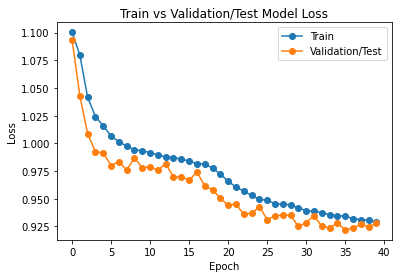

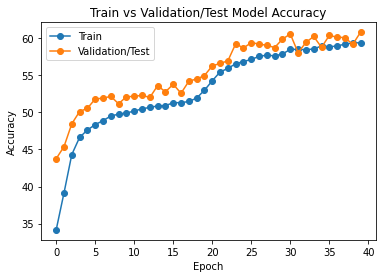


Calculating metrics...
Accuracy: 0.5730353593826294
Precision: [0.61871069 0.55441478 0.52826087]
Recall: [0.68974584 0.70990359 0.31945662]
F1 score: [0.65230004 0.622598   0.39814309]
Support: [2282 2282 2282]
              precision    recall  f1-score   support

         0.0       0.62      0.69      0.65      2282
         1.0       0.55      0.71      0.62      2282
         2.0       0.53      0.32      0.40      2282

    accuracy                           0.57      6846
   macro avg       0.57      0.57      0.56      6846
weighted avg       0.57      0.57      0.56      6846

None


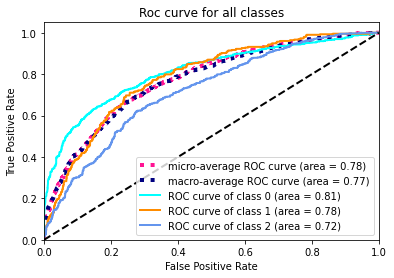

In [14]:
data_train_second_model('vaccine_train_set.csv', 'vaccine_validation_set.csv', 'glove_dict_25d.pkl', 'tweet', 'label')